Using device: mps
API Response: {
  "result": "error",
  "error_code": "107",
  "error_msg": "Parameter value is wrong"
}
Error fetching prices: Key error while parsing API response: "'bids' key not found in API response."
Falling back to synthetic price data...


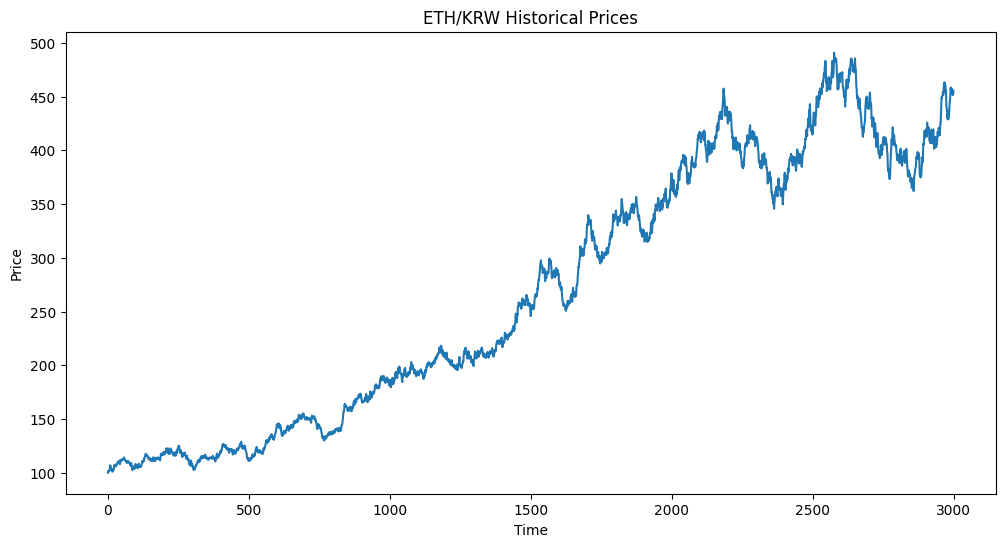

Episode 1/10, Reward: -26.32, PnL: -26.32, Eps: 0.901
Episode 2/10, Reward: 58.60, PnL: 58.60, Eps: 0.802
Episode 3/10, Reward: 28.60, PnL: 28.60, Eps: 0.703
Episode 4/10, Reward: -46.45, PnL: -46.45, Eps: 0.604
Episode 5/10, Reward: -24.11, PnL: -24.11, Eps: 0.505
Episode 6/10, Reward: 1.21, PnL: 1.21, Eps: 0.406
Episode 7/10, Reward: 2.74, PnL: 2.74, Eps: 0.307
Episode 8/10, Reward: 43.81, PnL: 43.81, Eps: 0.208
Episode 9/10, Reward: 59.11, PnL: 59.11, Eps: 0.109
Episode 10/10, Reward: 13.66, PnL: 13.66, Eps: 0.010


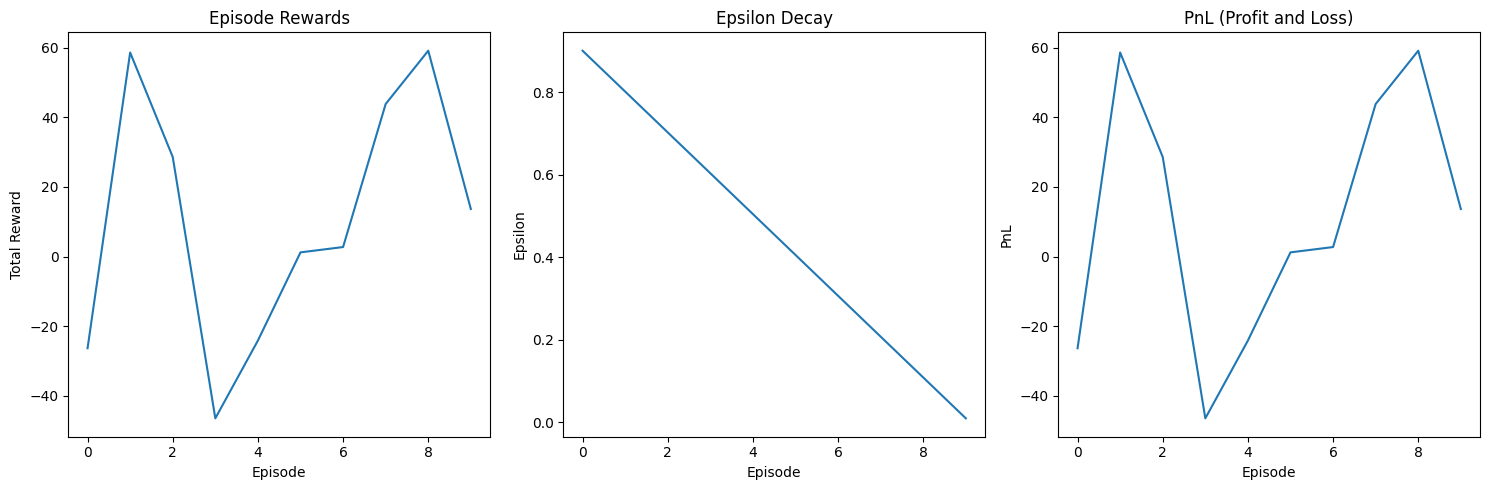


Training complete!



In [4]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import requests
import matplotlib.pyplot as plt
import uuid
import json
import base64
import hmac
import hashlib

# Device selection
device = torch.device(
    "mps" if torch.backends.mps.is_available() else 
    "cuda" if torch.cuda.is_available() else 
    "cpu"
)
print(f"Using device: {device}")

ACCESS_TOKEN = 'b8c8db4a-1afb-4bac-8d63-15e556a37357'
SECRET_KEY = bytes('3296ca08-538c-4dd4-8d70-568f30ca70ee', 'utf-8')

def get_encoded_payload(payload):
    payload['nonce'] = str(uuid.uuid4())
    dumped_json = json.dumps(payload)
    encoded_json = base64.b64encode(bytes(dumped_json, 'utf-8'))
    return encoded_json

def get_signature(encoded_payload):
    return hmac.new(SECRET_KEY, encoded_payload, hashlib.sha512).hexdigest()

def fetch_coinone_prices(coin="BTC", quote="KRW", limit=30):
    """
    Fetches cryptocurrency prices from Coinone API's orderbook or public endpoint.
    """
    url = f'https://api.coinone.co.kr/public/v2/orderbook/{quote}/{coin}?size={limit}'
    response = requests.get(url)

    if response.status_code == 200:
        try:
            data = response.json()
            # Print the response to debug
            print("API Response:", json.dumps(data, indent=2))

            # Check if 'bids' key exists
            if 'bids' not in data:
                raise KeyError("'bids' key not found in API response.")
            
            # Extract prices from the bids
            prices = [float(order['price']) for order in data['bids']]
            return np.array(prices, dtype=np.float32)
        except KeyError as e:
            raise Exception(f"Key error while parsing API response: {e}")
        except Exception as e:
            raise Exception(f"Unexpected error: {e}")
    else:
        raise Exception(f"HTTP Error: {response.status_code}, {response.text}")

class StockTradingEnv:
    def __init__(self, prices, window_size=30, initial_capital=10000, max_steps=1000):
        self.prices = prices
        self.window_size = window_size
        self.initial_capital = initial_capital
        self.max_steps = min(max_steps, len(prices) - window_size - 1)
        self.reset()

    def reset(self):
        self.current_step = 0
        self.done = False
        self.position = 0
        self.capital = self.initial_capital
        self.last_price = self.prices[self.window_size - 1]
        return self._get_observation()

    def _get_observation(self):
        start = self.current_step
        end = self.current_step + self.window_size
        return self.prices[start:end]

    def step(self, action):
        if self.done:
            return self._get_observation(), 0.0, True, {}

        new_position = -1 if action == 0 else (1 if action == 2 else 0)
        current_price = self.prices[self.current_step + self.window_size - 1]
        reward = 0.0

        if self.position != 0:
            reward += (current_price - self.last_price) * self.position

        self.position = new_position
        self.last_price = current_price
        self.current_step += 1

        if self.current_step >= self.max_steps:
            self.done = True
            if self.position != 0:
                final_price = self.prices[self.current_step + self.window_size - 1]
                reward += (final_price - self.last_price) * self.position

        return self._get_observation(), reward, self.done, {}

def generate_synthetic_prices(T=3000, s0=100, mu=0.0005, sigma=0.01):
    """
    Generates synthetic price data for debugging or fallback.
    """
    prices = [s0]
    for t in range(1, T):
        prices.append(prices[-1] * math.exp((mu - 0.5 * sigma**2) + sigma * random.gauss(0, 1)))
    return np.array(prices, dtype=np.float32)

def get_epsilon(it, max_it, min_epsilon=0.01, max_epsilon=1.0):
    slope = -(max_epsilon - min_epsilon) / max_it
    return max(min_epsilon, max_epsilon + slope * it)

def process_state_transformer(state):
    if isinstance(state, np.ndarray):
        state = torch.FloatTensor(state).to(device)
    return state.unsqueeze(0).unsqueeze(-1)

def plot_metrics(rewards_history, eps_history, pnl_history):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(rewards_history)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    plt.subplot(1, 3, 2)
    plt.plot(eps_history)
    plt.title('Epsilon Decay')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')

    plt.subplot(1, 3, 3)
    plt.plot(pnl_history)
    plt.title('PnL (Profit and Loss)')
    plt.xlabel('Episode')
    plt.ylabel('PnL')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    coin = input("Enter the cryptocurrency (e.g., BTC): ").strip().upper()
    quote = input("Enter the quote currency (e.g., KRW): ").strip().upper()

    try:
        prices_array = fetch_coinone_prices(coin=coin, quote=quote, limit=300)
        if len(prices_array) == 0:
            raise ValueError("API returned empty price data.")
    except Exception as e:
        print(f"Error fetching prices: {e}")
        print("Falling back to synthetic price data...")
        prices_array = generate_synthetic_prices(T=3000)

    if prices_array is None or len(prices_array) == 0:
        print("Failed to initialize prices array. Exiting.")
        exit(1)

    plt.figure(figsize=(12, 6))
    plt.plot(prices_array)
    plt.title(f'{coin}/{quote} Historical Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.show()

    env = StockTradingEnv(prices_array, window_size=30, initial_capital=10000, max_steps=1000)
    trained_qnet, rewards_history = train_dqn(env, num_episodes=10, window_size=30, gamma=0.99, lr=1e-3, batch_size=32, max_steps_per_episode=1000)
    print("\nTraining complete!\n")
